Kaggle link: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

WANDB: https://wandb.ai/ales-2000-09/Dogs%20vs%20Cats%20Castelli%20Alessandro 



My Code: https://www.kaggle.com/code/alessandromajumba/ex4-ml

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import everything needed

In [ ]:
import zipfile
import glob
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Label")

import wandb
wandb.login(key=secret_value_0)
wandb.init(project='Dogs vs Cats Castelli Alessandro', save_code=True)

## Unzip datasets

In [ ]:
train_dir = 'train'
test_dir = 'test'
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip') as train_zip:
    train_zip.extractall('')
    
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip') as test_zip:
    test_zip.extractall('')
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

In [4]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Plot random image with their label

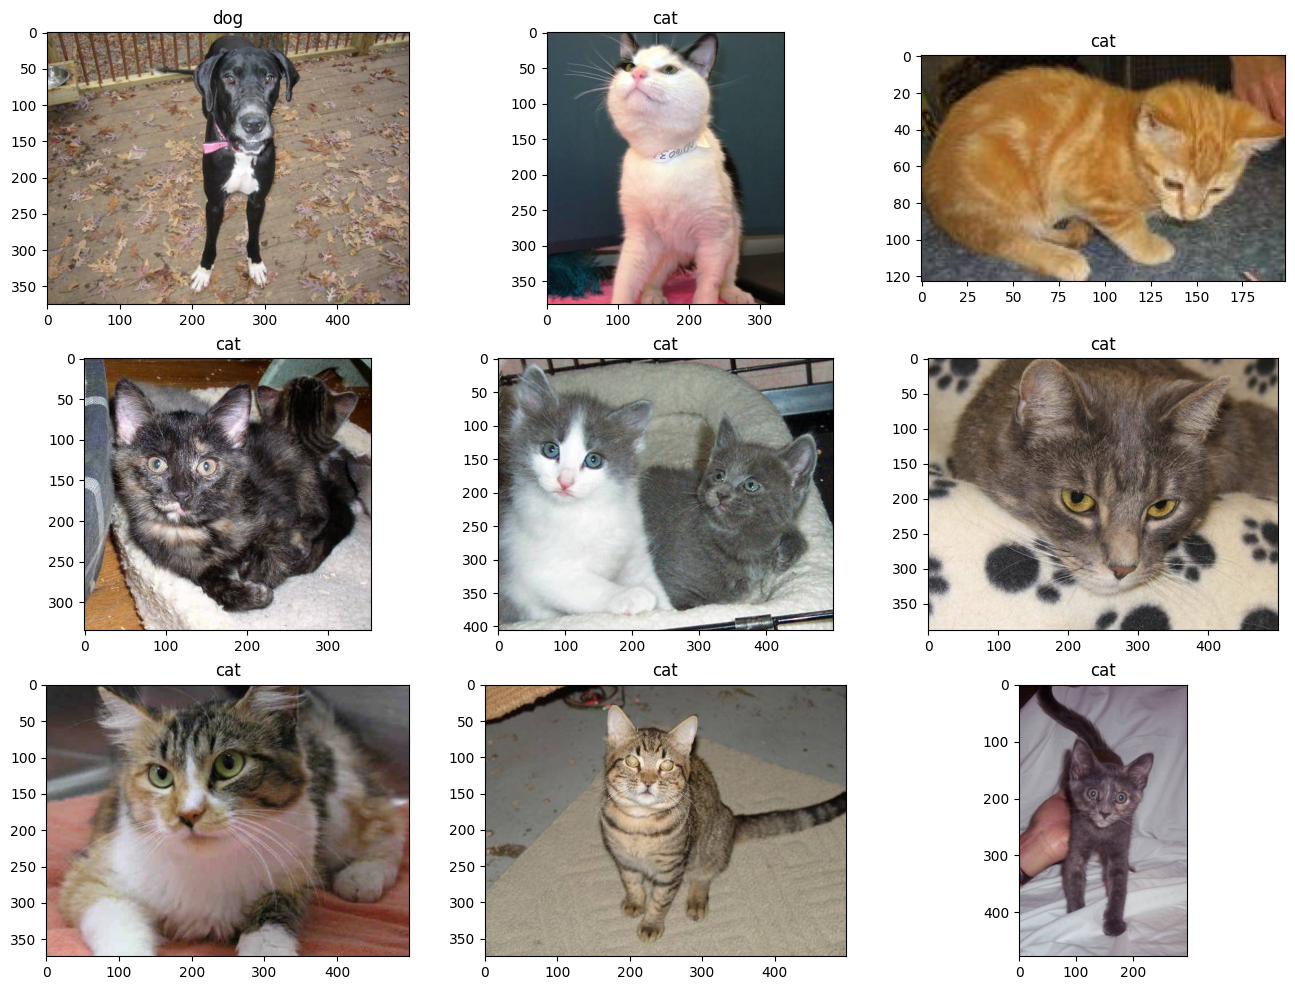

In [5]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

## Use Sklearn to split the training data

In [6]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=0)

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

We will discuss this in more detail in a near future...

In [8]:
# Define training transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop the image and resize it to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),               # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Define test transformations
test_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop the image and resize it to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),               # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

Define the dataset using PIL to read image

In [9]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.filelength = len(file_list)

    def __len__(self):
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [10]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

Create dataloader, you can modify the batch size if needed

In [11]:
batch_size = 16
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [14]:
# Define the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
wandb.log({'LR': lr})

In [ ]:
# Training loop
epochs = 128

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 99:  # Print every 100 batches
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {running_loss/100:.4f}")
            running_loss = 0.0

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    valid_loss = 0.0


    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_loss += criterion(outputs, labels).item()


    valid_accuracy=correct/total
    valid_loss /= len(valid_loader)
    train_loss = {running_loss/len(train_loader)}
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy*100:.2f}%")
    wandb.log({'Train Loss': train_loss})
    wandb.log({'Valid Loss': valid_loss})
    wandb.log({'Valid Acc': valid_accuracy*100})
    wandb.log({'num_epochs': epoch+1})

# Testing loop
model.eval()
predictions = []

with torch.no_grad():
    for batch_idx, (inputs, _) in enumerate(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        predictions.extend(probs.cpu().numpy())

        if batch_idx % 100 == 99:  # Print every 100 batches
            print(f"Testing Batch {batch_idx+1}/{len(test_loader)}")
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
wandb.log({'Test Acc': test_accuracy*100})

wandb.finish()

In [ ]:
# Save predictions to submission.csv
test_ids = [int(os.path.splitext(os.path.basename(path))[0]) for path in test_list]
predictions_array = np.array(predictions)  # Convert the list of arrays to a numpy array
submission_df = pd.DataFrame({'id': test_ids, 'label': predictions_array[:, 1]})
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

print("Testing completed. Submission file saved as 'submission.csv'")
